# Laying out a Mach-Zehnder Interferometer

This page will walk you through the steps of laying out an MZI for fabrication. In the last tutorial we learned how to use Simphony to simulate an MZI, and now we will learn to prepare a GDS file using the SiEPIC PDK. First we need to install the [ubcpdk package](https://gdsfactory.github.io/ubc/index.html). Following the installation instructions, we add it to our environment. 

```bash
conda install -c conda-forge gdstk -y
pip install ubcpdk --upgrade
```

Then we can play with the components. 

In [1]:
import gdsfactory as gf

import ubcpdk
import ubcpdk.components as uc

gf.CONF.display_type = "klayout"

2024-01-29 10:08:41.400 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/ubcpdk/layers.yaml'.
2024-01-29 10:08:42.302 | INFO     | ubcpdk:<module>:30 - Found UBCpdk '2.3.4' installed at PosixPath('/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/ubcpdk')
2024-01-29 10:08:42.375 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/generic_tech/layer_views.yaml'.
2024-01-29 10:08:42.379 | INFO     | gdsfactory.pdk:activate:307 - 'ubcpdk' PDK is now active


First, we can get a basic idea of what is going on by looking at a Y splitter. The code below creates the splitter, then plots it. pretty simple. The Y splitter is a fixed component in the PDK, which in this case means that it doesn't take any arguments and we can't change its geometry. All the components available in the PDK can be found in the [docs](https://gdsfactory.github.io/ubc/components.html).

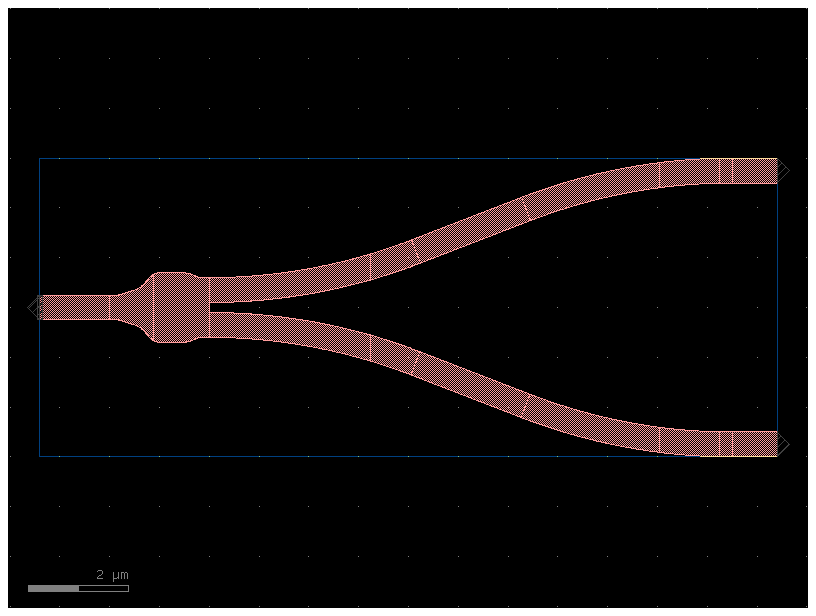

In [4]:
y = uc.ebeam_y_1550()
y.plot()

Now let's look at a component we can play with. We'll use a single-coupled ring. The ring has many features we can adjust, which are all listed in the [docs](https://gdsfactory.github.io/ubc/components_plot.html#ubcpdk.components.ring_single). For now we'll just play with the gap, the radius (of the bends), the length_x (which is the coupler length), and the length_y. Try a few of these values to try them out. 

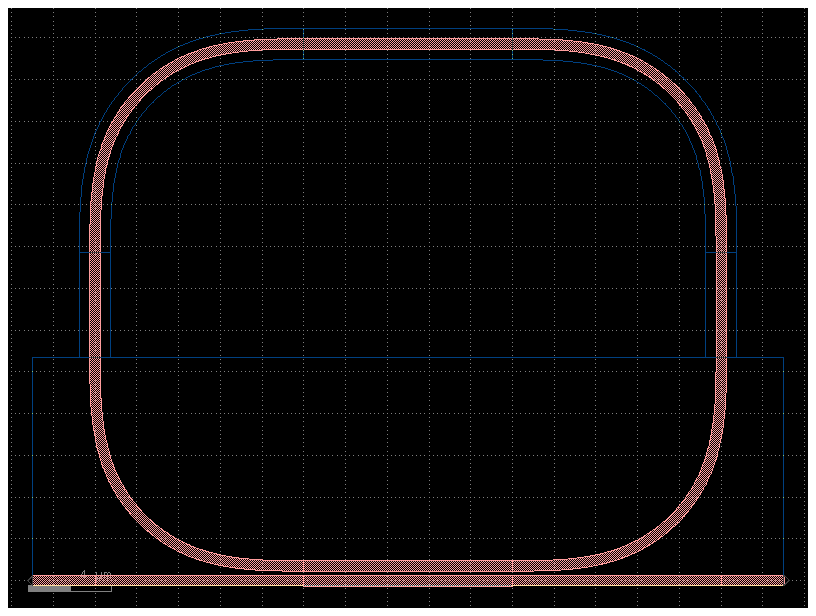

In [6]:
ring = uc.ring_single(gap=0.2, length_x=10, length_y=5, radius=10)
ring.plot()

Now let's make an MZI. First we will just see what the default parameters give us. 

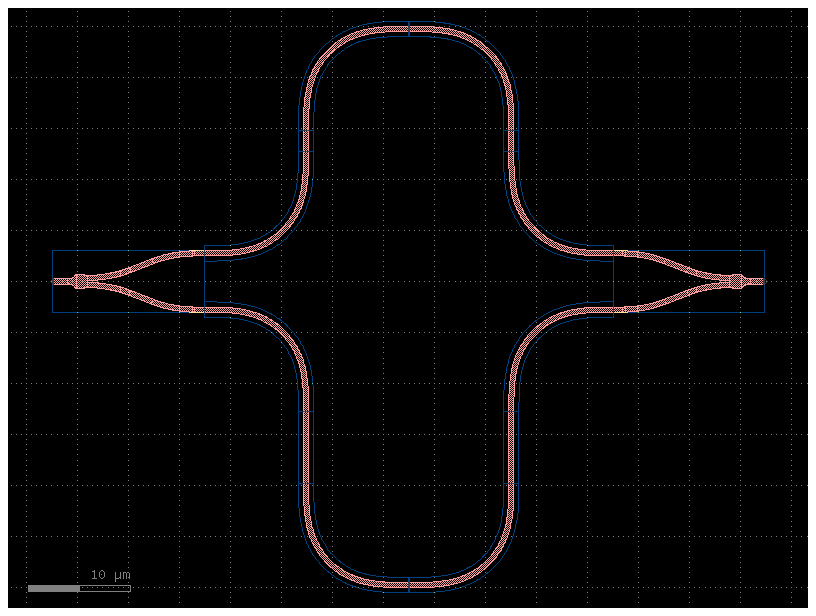

In [13]:
mzi = uc.mzi()
mzi.plot()

Now we can play around a little bit. First, we can change various lengths. We find the parameters in the [docs](https://gdsfactory.github.io/ubc/components_plot.html#ubcpdk.components.mzi). There is an ASCII drawing there that is helpful to understand what the different length parameters do.

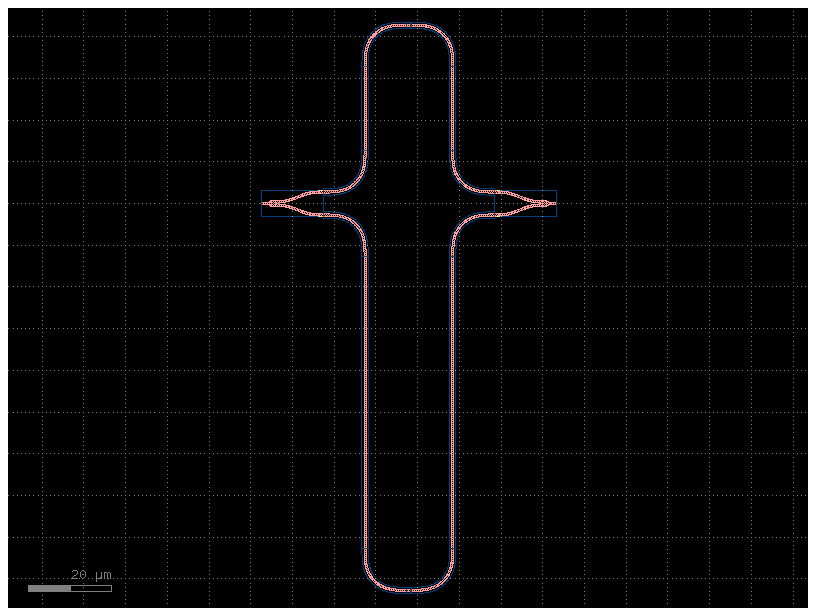

In [2]:
mzi = uc.mzi(delta_length=100, length_x=1, length_y=20)
mzi.plot()

Finally, we can easily add a grating array to any component. Note that the component we want to add gratings to will be rotated so that its ports are oriented vertically. Also, though we can't see it in the plot, adding the grating couplers also adds a label to one of the gratings, marking it as the input. 

:::{warning}
The label is essential for the automated testing that is part of the OpenEBL fabrication run. The label tells the tester what polarization to use, which port is the input, and what to name the data set it collects. 
:::

We can set the device name on this label usig the 'component_name' argument. The [docs](https://gdsfactory.github.io/ubc/components_plot.html#ubcpdk.components.add_fiber_array) are always helpful. However, we also need to set our username for the labels. The username will be used to help you find your data after testing. To set your username, you have to create a configuration (or YAML) file in your working directory. To do this, create a new file named config.yml in the same directory as your code. This file will contain only one line: 

```bash

username: "YourName"

```

You may need to restart your kernel after creating the configuration file.

:::{warning}
The file must be named config.yml and must be placed in the same directory as your code. It will contain the line ```username: "YourName"```
:::

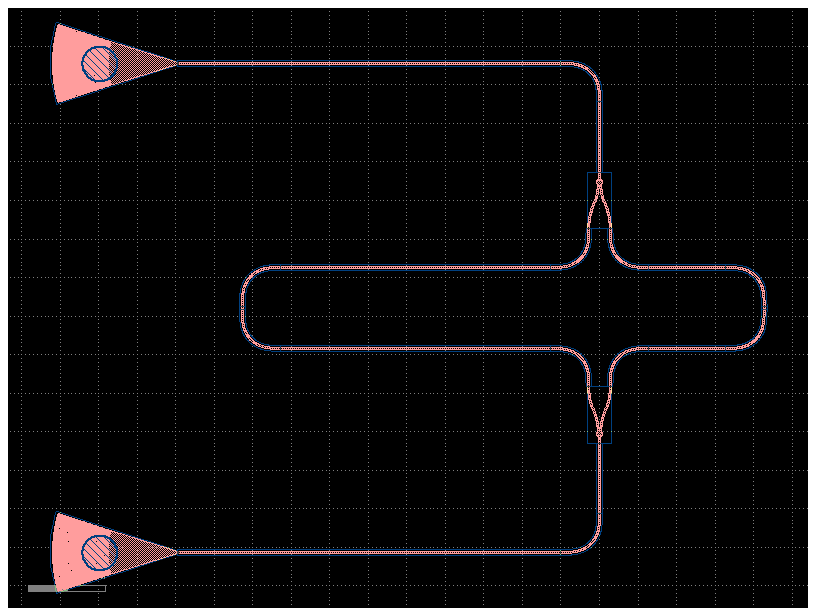

In [3]:
TE_MZI = uc.add_fiber_array(component=mzi, component_name='MyCoolMZI1')
TE_MZI.plot()

We can also change the grating coupler to a TM coupler by passing in a TM coupler. We also can flip the direction of the mzi. This isn't really useful for the MZI but can help us make sure the right port is the input in other cases. 

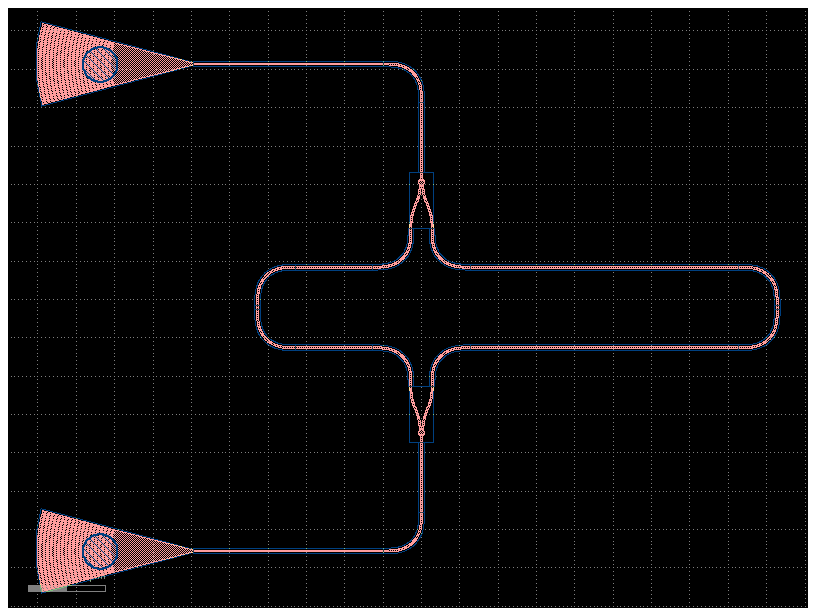

In [4]:
TM_MZI = uc.add_fiber_array(component=mzi.rotate(180), grating_coupler=uc.gc_tm1550, component_name='MyCoolMZITM')
TM_MZI.plot()

Now we should put them together to make our 'final' design. We can use the [distribute](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_pack.html#distribute) and [align](https://gdsfactory.github.io/gdsfactory/notebooks/04_components_pack.html#align) functions.

/home/parkeraa/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/component.py:1569: UserWarning: Unnamed cells, 1 in 'Unnamed_a784d514'
  gdspath = component.write_gds(logging=False)


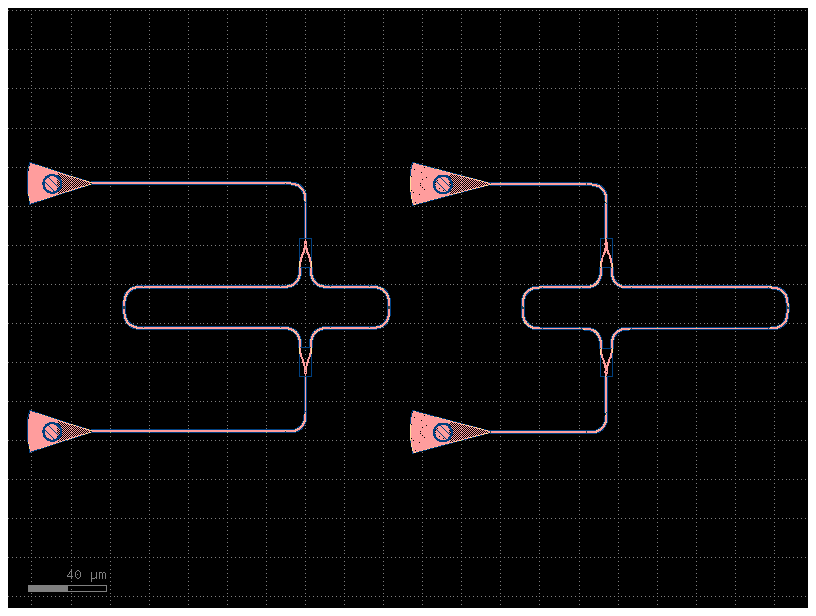

In [5]:
mzi_together = gf.Component()
mzi_together.add_ref(TE_MZI)
mzi_together.add_ref(TM_MZI)

mzi_together.distribute(direction='x', spacing=10)
mzu_together = mzi_together.align(alignment='ymax')
mzi_together.plot()

We can export our design using the write_gds function. If you zoom in on where the lower coupler meets the waveguide, you can see the text label. It should say:

```bash
opt_in_TE_1550_device_YourName_MyCoolMZI1
```

In [7]:

mzi_together.write_gds("mzi.gds")

/tmp/ipykernel_322436/1677396279.py:1: UserWarning: Unnamed cells, 1 in 'Unnamed_a784d514'
  mzi_together.write_gds("mzi.gds")
2024-01-29 10:09:05.044 | INFO     | gdsfactory.component:_write_library:1913 - Wrote to 'mzi.gds'


PosixPath('mzi.gds')